In [20]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from pathlib import Path

In [21]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [23]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [24]:
# Create engine using the `hawaii.sqlite` database file
Data = Path("../Resources/hawaii.sqlite")
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [25]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [26]:
Measurement = Base.classes.measurement
Station = Base.classes.station
session = Session(engine)
print(Measurement)
print(Station)

<class 'sqlalchemy.ext.automap.measurement'>
<class 'sqlalchemy.ext.automap.station'>


In [29]:
measurement_df = pd.read_sql("SELECT * FROM measurement", engine)
measurement_df

,id,station,date,prcp,tobs
0,0,USC00519397,2010-01-01,2.0,18.3
1,1,USC00519397,2010-01-02,0.0,17.2
2,2,USC00519397,2010-01-03,0.0,23.3
3,3,USC00519397,2010-01-04,0.0,24.4
4,4,USC00519397,2010-01-06,NaN,22.8
...,...,...,...,...,...
19545,19545,USC00516128,2017-08-19,2.3,21.7
19546,19546,USC00516128,2017-08-20,NaN,25.6
19547,19547,USC00516128,2017-08-21,14.2,24.4
19548,19548,USC00516128,2017-08-22,12.7,24.4


In [30]:
station_df = pd.read_sql("SELECT * FROM station", engine)
station_df

,id,station,name,latitude,longitude,elevation
0,0,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,0.914
1,1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,4.450
2,2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,2.133
3,3,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,3.627
4,4,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,93.447
5,5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,5.943
6,6,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,10.027
7,7,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.274
8,8,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,46.449


# Exploratory Precipitation Analysis

In [34]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()

# Convert the most_recent_date string to a datetime object
most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')

most_recent_date

datetime.datetime(2017, 8, 23, 0, 0)

In [40]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame. Explicitly set the column names
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data

one_year_ago = most_recent_date - dt.timedelta(days=365)

precipitation_data = session.query(Measurement.date, Measurement.prcp)\
    .filter(Measurement.date >= one_year_ago)\
    .order_by(Measurement.date)\
    .all()

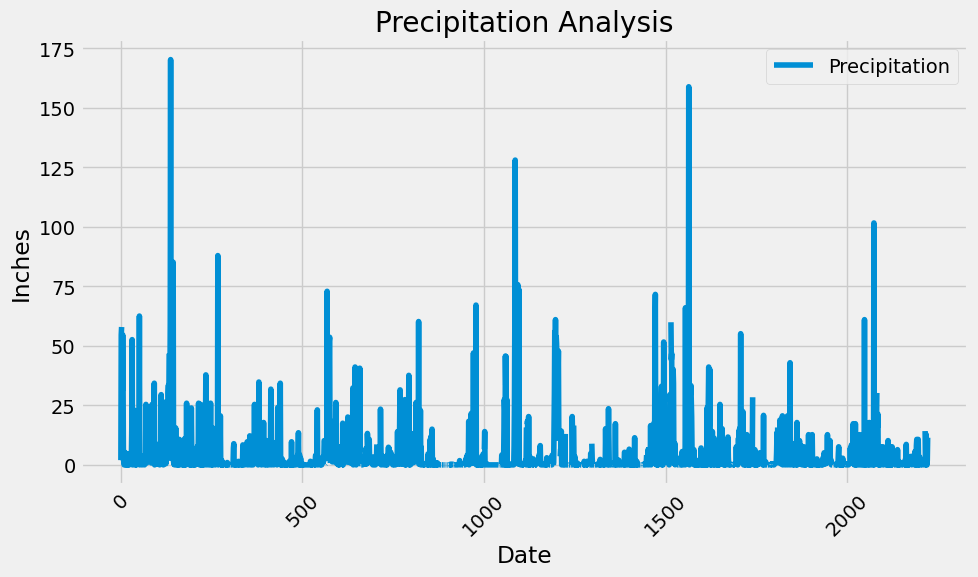

In [41]:
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])
precipitation_df.sort_index(inplace=True)
precipitation_df.plot(figsize=(10, 6), title='Precipitation Analysis', xlabel='Date', ylabel='Inches', legend=True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [44]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = precipitation_df.describe()
print(summary_statistics)

# Close the session
session.close()

       Precipitation
count    2015.000000
mean        4.485112
std        11.690532
min         0.000000
25%         0.000000
50%         0.500000
75%         3.300000
max       170.200000


# Exploratory Station Analysis

In [47]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print(f"Total number of stations is {total_stations}")

Total number of stations is 9


In [48]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_station = session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc())\
    .first()

most_active_station_id = most_active_station[0]
observation_count = most_active_station[1]

print(f"\nMost-active station ID: {most_active_station_id}")
print(f"Observation count for the most-active station: {observation_count}")


Most-active station ID: USC00519281
Observation count for the most-active station: 2772


In [50]:
temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
    .filter(Measurement.station == most_active_station_id)\
    .first()

lowest_temp = temperature_stats[0]
highest_temp = temperature_stats[1]
average_temp = temperature_stats[2]

print(f"\nLowest Temperature: {lowest_temp}°F")
print(f"Highest Temperature: {highest_temp}°F")
print(f"Average Temperature: {average_temp:.2f}°F")


Lowest Temperature: 12.2°F
Highest Temperature: 29.4°F
Average Temperature: 22.04°F


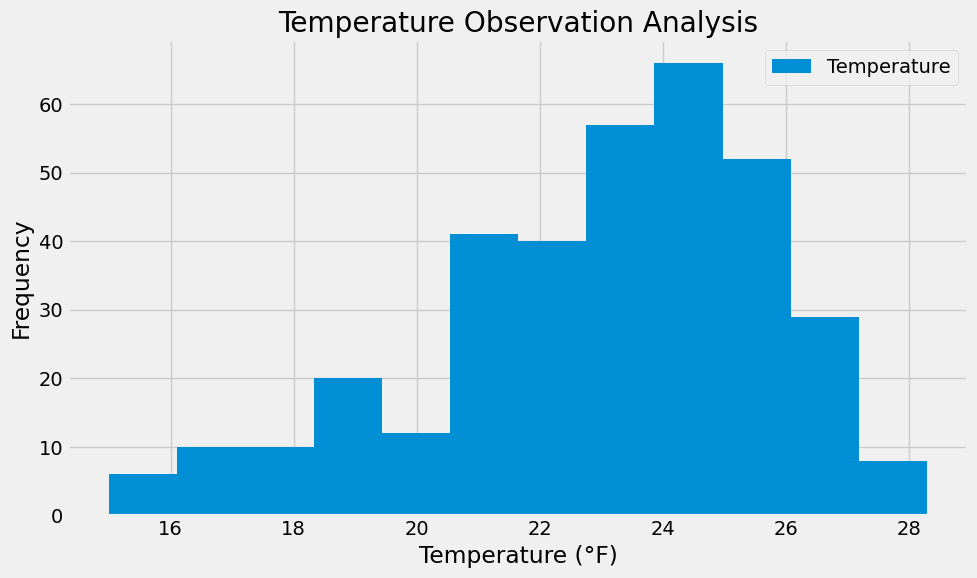

In [53]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station_data = session.query(Measurement.date, Measurement.tobs)\
    .filter(Measurement.station == most_active_station_id)\
    .filter(Measurement.date >= one_year_ago)\
    .all()
    
most_active_station_df = pd.DataFrame(most_active_station_data, columns=['Date', 'Temperature'])

most_active_station_df.plot.hist(bins=12, figsize=(10, 6), title='Temperature Observation Analysis',
                                 xlabel='Temperature (°F)', ylabel='Frequency', legend=True)
plt.tight_layout()
plt.show()
session.close()

# Close Session

In [54]:
# Close Session
session.close()
